<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/05-Medidas_de_Performance_Avaliacao_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROC: Avaliação de Classificadores Binários
---

Em problemas de classificação binária (distinguir sinal de ruído)  a medida de performance frequentemente é a **acurácia**, porém as vezes uma alta acurácia vem a um custo  de **ineficiência**.
---

## A curva ROC
A sigla ROC vem de ***receiving operator characteristic***, pois foi ideado originalmente para detectar objetos em radares, ou também ***relative operator characteristic*** pois relaciona duas caraterísticas do "operador", a precisão e a eficiência.

Primeiro devemos esclarecer as definições dos conceitos acima. Vamos ter em mente a *matriz confusão*:


|*Resposta*| Sinal | Ruido | ***Total*** |
|----------| ------|------ |-------------|
|*Negativo*|  <font color=orangered >$F_N$ </font>| <font color=springgreen> $V_N$</font> |         $N$ |
|*Positivo*| <font color=springgreen >$V_P$</font> | <font color=orangered> $F_P$</font>  |        $P$ |
|**Total** | $$S$$   |  $$B $$  |  $$T = N+P = S+B$$  |


Onde a soma das linhas:
 $$ P = V_P + F_P  \;\;\; \mathrm{e} \;\;\; N = F_N + V_N $$
e a soma das colunas:
 $$ S = V_P + F_N  \;\;\; \mathrm{e} \;\;\; B = V_N + F_P $$

---

### Definições :
   * **Acurácia**: fração das instâncias classificadas corretamente (seja como sinal ou background)
$$ a = \dfrac{V_P + V_N}{T} $$
   * **Precisão**: fração das instâncias de sinal corretamente classificadas como positivas. Também chamada de *pureza*.
   $$ p = \dfrac{V_P}{P}$$
   * **Eficiência**: fração do sinal que foi corretamente classificado de forma positiva. Também chamado de *recall* (as vezes traducido como ___revocação___) ou **TPR** (*true positive rate*).
   $$ \epsilon = \dfrac{V_P}{S}$$
   * **Especificidade**: fração de background corretamente classificado de forma negativa, também conhecido de  **TNR** (*true negative rate*) e seria equivalente à eficiência em identificar o ruído (a.k.a. *background rejection*)
   $$ \epsilon_{B} = \dfrac{V_N}{B} $$  
   * ***False Positive Rate***: (**FPR**) é a fração das instâncias de background classificadas incorretamente de forma positiva.
   $$ f_{FP} = \dfrac{F_P}{B} = 1-\epsilon_B$$
   * ***False Negative Rate***: (**FNR**) é a fração das instâncias de sinal classificadas incorretamente de forma negativa, i.e. a *ineficiência* do sinal.
   $$ f_{FN} = \dfrac{F_N}{S} = 1 - \epsilon$$

---

### Observações :
 * Nas curvas ROC geralmente  é graficado no eixo $y$ a eficiência (a.k.a. recall ou TPR) que queremos ser o máximo possível e no eixo $x$ o FPR ($f_{FP}$ que é  $1 -$ TNR) que deveria ser pequeno.

 * Porém quando nosso sinal é raro ou estamos mais preocupados dos falsos positivos que dos falsos negativos é preferível usar a curva chamada *PR* (*precision-recall*, ou seja pureza vs eficiência)


 * Na área da saúde pode ser mais importante conhecer e optimizar em função da especificidade (excepto em epidemias ou doenças muito raras), mas em física de altas energias por exemplo ela é irrelevante.

 * Específicamente para medicina também é importante conhecer a ***prevalência*** de um sinal  (ou doença), quer dizer quão frequênte ela é na população.

$$ \pi_s = \dfrac{S}{T}$$

![PRCROC_ideal](https://github.com/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/pics/Figure-B5-Examples-of-a-PR-curve-and-a-ROC-curve-The-red-plot-shows-ideal-PR-and-ROC.png?raw=true)

### Exemplo: Classificação binaria de um dígito

Quer dizer, queremos que nosso classificador decida se é ou não um número 5, por exemplo.

In [49]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [50]:
X, y = mnist["data"], mnist["target"]
print(X.shape,y.shape)
Xnp= X.to_numpy()
print(Xnp.shape)

(70000, 784) (70000,)
(70000, 784)


In [51]:
ynp=y.to_numpy()

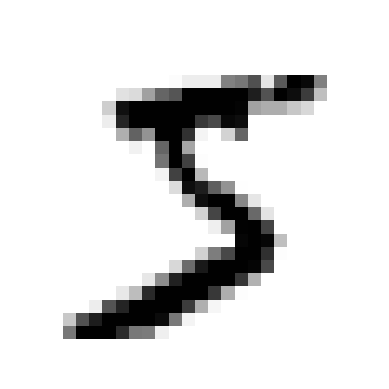

5


In [52]:
some_digit = Xnp[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print(y[0])

In [53]:
#algumas definições úteis
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

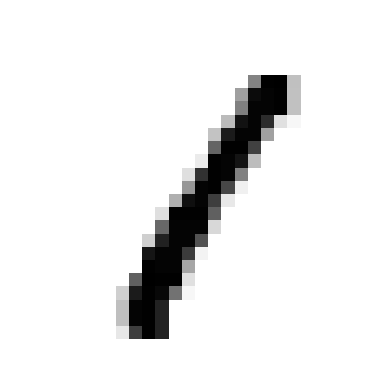

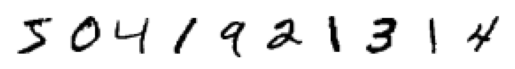

In [54]:
plot_digit(Xnp[3])
plt.show()
plot_digits(Xnp[0:10])

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xnp,ynp,test_size=10000,random_state=42)

Agora redefinimos o alvo ($y$) para ter um resultado binário: Sim ou Não (ou *verdadeiro ou falso*). O sinal (ou Sim) é o dígito 5.

In [56]:
y_train_5 = (y_train == '5')
y_test_5  = (y_test == '5')


Chamamos agora um modelo de ***Stochastic Gradient Descent*** para classificar os dados. Por default é um SVM,  [vide documentação](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [57]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

[ True]


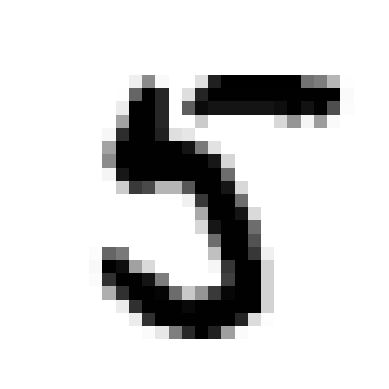

[False]


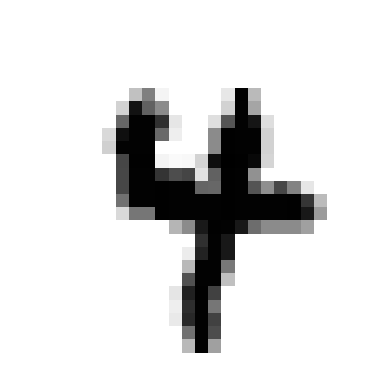

In [58]:
print(sgd_clf.predict([X_test[15]]))
plot_digit(X_test[15])
plt.show()
print(sgd_clf.predict([X_test[1]]))
plot_digit(X_test[1])
plt.show()

In [59]:
y_predict_5 = sgd_clf.predict(X_test)

## Validação Cruzada
Agora podemos testar a acurácia do modelo com _cross-validation_, nesse caso com 3 sub-conjuntos aleatórios dos dados de treinamento, e também a validação do conjunto de teste.

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score

print(cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy"))


[0.9629  0.96775 0.96435]


In [61]:
print("acuracia = {:2.3f} ".format(accuracy_score(y_test_5,y_predict_5)))
print("precisao = {:2.3f} e eficiencia = {:2.3f}".format(precision_score(y_test_5,y_predict_5),recall_score(y_test_5,y_predict_5)))

acuracia = 0.966 
precisao = 0.853 e eficiencia = 0.767


Para comparação, podemos criar um classificador que nunca responde sim. A classe não faz nada no fit  e na predição vai dar sempre a resposta negativa. Qual será a acurácia desse classificador?

In [62]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Chamaos a validação do modelo e tanto na cross-validation quanto na validação no teste dá uma acurácia de ~90%

In [63]:
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))
y_pred_never_5=never_5_clf.predict(X_test)
print(accuracy_score(y_test_5,y_pred_never_5))

[0.9119  0.90875 0.91055]
0.9063


Mas se pesquisamos a precisão e eficiência, elas são zero (ou seja todas as instâncias negativas são classificadas corretamente, mas nenhuma das instâncias positivas)

In [64]:
print(precision_score(y_test_5,y_pred_never_5),recall_score(y_test_5,y_pred_never_5))


0.0 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recapitulando, a predição de "chutar" todas as predições como não sendo o dígito 5 dá certo ~90% do tempo pois ~1/10 dos dígitos nos dados são 5, então reflete a *prevalência* do sinal. Mas se examinarmos a precisão (pureza) e a eficiência (*recall*) vemos que esse mêtodo não tem boa performance.

Exercício : implemente outro classificador "bobo" que chute com probabilidade de 50% a resposta negativa ou positiva. Avalie a acurária, precisão e eficiência.



## Matriz confusão com o SciKit Learn

Para maior informação do módulo de validação cruzada, vide o site do [SciKit Learn Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

In [65]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


O vetor de sufixo ``predallzero`` simplesmente é o nosso classificador que responde sempre negativo, o ``predperfect`` é o classificador "trapaceiro" que classifica tudo corretamente porque colou.

In [66]:
y_train_predallzero = never_5_clf.predict(X_train)
y_train_predperfect = y_train_5

In [67]:
from sklearn.metrics import confusion_matrix
print("Test sample confusion matrix")
print(confusion_matrix(y_test_5,y_predict_5))
print("\n")
print("Training sample confusion matrix")
print(confusion_matrix(y_train_5, y_train_pred))

Test sample confusion matrix
[[8939  124]
 [ 218  719]]


Training sample confusion matrix
[[54103   521]
 [ 1579  3797]]


In [68]:
print("Perfect score confusion matrix")
print(confusion_matrix(y_train_5, y_train_predperfect))

Perfect score confusion matrix
[[54624     0]
 [    0  5376]]


In [69]:
print("Never 5 confusion matrix")
print(confusion_matrix(y_train_5, y_train_predallzero))

Never 5 confusion matrix
[[54624     0]
 [ 5376     0]]


O resultado do valor da precisão e da eficiência para o modelo SGD é

In [70]:
print("precision {:2.1f}%".format(100*precision_score(y_train_5, y_train_pred)))
print("recall {:2.1f}%".format(100*recall_score(y_train_5,y_train_pred)))

precision 87.9%
recall 70.6%


Para acessar os valores da função de decisão:

In [71]:
y_scores = sgd_clf.decision_function(X_train)
y_scores[0]

np.float64(-14144.506062058408)

A função `precision_recall_curve` retorna os valores de pureza e eficiência do método a medida que muda o *threshold* da decisão

In [89]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Podemos salvar o ponto limite onde a precisão/pureza alcança 90%. Neste ponto, quanto é o valor da eficiência?

In [90]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print("Ponto de corte onde alcança precisão >90% :",threshold_90_precision)

recall_90_precision = recalls[np.argmax(precisions>=0.9)]
print("Eficiência para aquele ponto de corte (precisão>90%) :", recall_90_precision)

Ponto de corte onde alcança precisão >90% : 483.1147511086346
Eficiência para aquele ponto de corte (precisão>90%) : 0.7345610119047619


A distribuiçao desses valores para sinal e background pode nos ajudar entender as métricas encontradas.

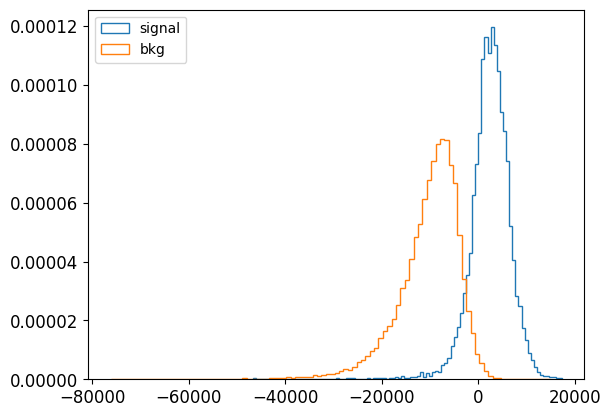

In [74]:
plt.hist(y_scores[y_train_5],histtype='step',density=True,label='signal',bins=100)
plt.hist(y_scores[~y_train_5],histtype='step',density=True,label='bkg',bins=100)
plt.legend()
plt.show()

A função definida embaixo ajuda a fazer o gráfico da evolução da pureza e recall com o valor do *threshold* de desição. O *threshold* de 90% de pureza está indicado em vermelho.

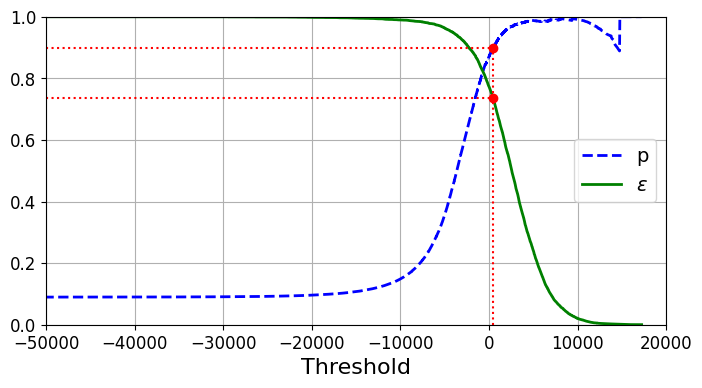

In [78]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="p", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="$\epsilon$", linewidth=2)
    plt.legend(loc="center right", fontsize=14)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 20000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

A curva PRC então pode ser graficada a a seguir

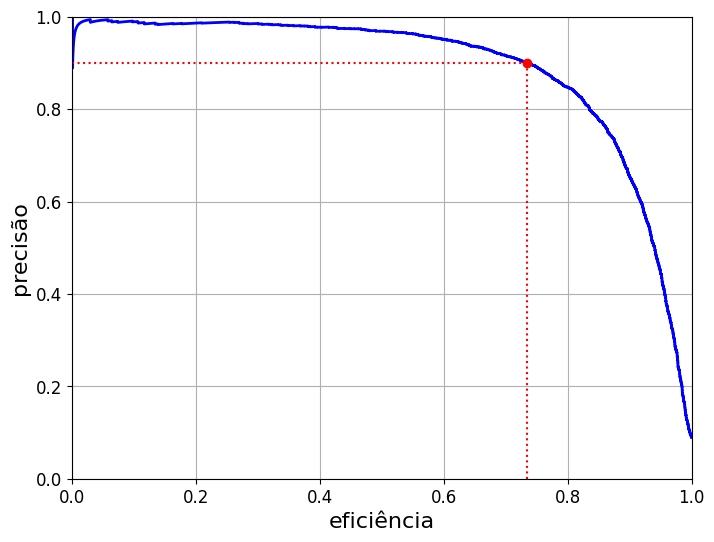

In [79]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("eficiência", fontsize=16)
    plt.ylabel("precisão", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [94]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precisão (>90%): {:2.2%}".format (precision_score(y_train_5,y_train_pred_90)))
print("Acurácia para precisão > 90%: {:2.2%} ".format(accuracy_score(y_train_5,y_train_pred_90)))
rec_point = recall_score(y_train_5,y_train_pred_90)
print("Eficiência para precisão > 90%: {:2.2%}".format(rec_point))


Precisão (>90%): 90.02%
Acurácia para precisão > 90%: 96.89% 
Eficiência para precisão > 90%: 73.46%


A curva ROC relaciona outras métricas: o *false positive rate* e o *true positive rate* (recall).

In [81]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [82]:
fpr_point = fpr[np.argmax(thresholds<=threshold_90_precision)]
print("{:2.4e}".format(fpr_point))

## entrega o valor de taxa de falsos positivos no ponto de corte que achamos precisão >90%

8.0368e-03


No gráfico o ponto de 90% de pureza tem 0.8% de taxa de falsos negativos.

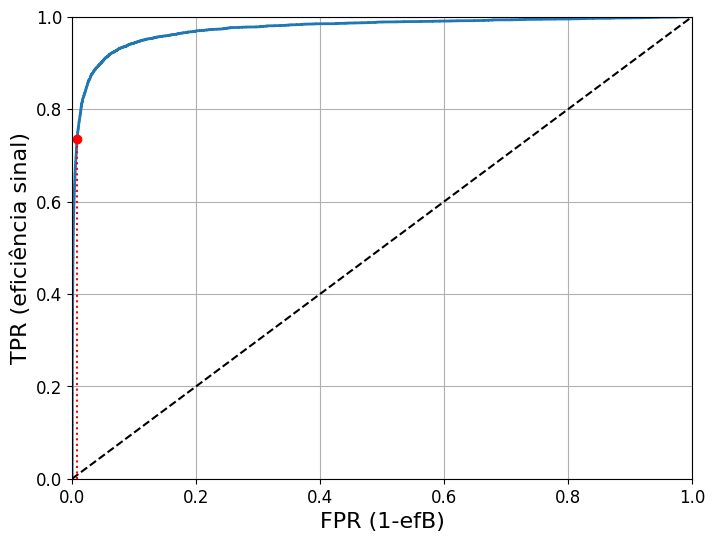

In [83]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('FPR (1-efB)', fontsize=16) # Not shown
    plt.ylabel('TPR (eficiência sinal)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_point, fpr_point], [0., rec_point], "r:") # Not shown
plt.plot([0.0, fpr_point], [rec_point, rec_point], "r:")  # Not shown
plt.plot([fpr_point], [rec_point], "ro")               # Not shown
                        # Not shown
plt.show()

Um possível índice de performance é a área sob a curva ROC (AUC)

In [85]:
from sklearn.metrics import roc_auc_score

AUC=roc_auc_score(y_train_5, y_scores)
print(AUC)

0.9741394824488451


## Avaliação numa floresta aleatória

Agora podemos comparar com um modelo de **RandomForest**

In [95]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [96]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
prec_forest, rec_forest, threshs_frst = precision_recall_curve(y_train_5, y_scores_forest)

In [97]:
thr_frst_90 = threshs_frst[np.argmax(prec_forest>=0.9)]
print("limiar para precision de 0.9 ===>  ", thr_frst_90)
y_pred_frst_90 = (y_scores_forest >= thr_frst_90)
rec_pnt_frst = rec_forest[np.argmax(y_pred_frst_90)]
fpr_pnt_frst = fpr_forest[np.argmax(y_pred_frst_90)]
print("recall neste limiar = ", rec_pnt_frst)
print("taxa de falsos positivos neste limiar= ",fpr_pnt_frst)

limiar para precision de 0.9 ===>   0.24
recall neste limiar =  0.9719122023809523
taxa de falsos positivos neste limiar=  7.322788517867604e-05


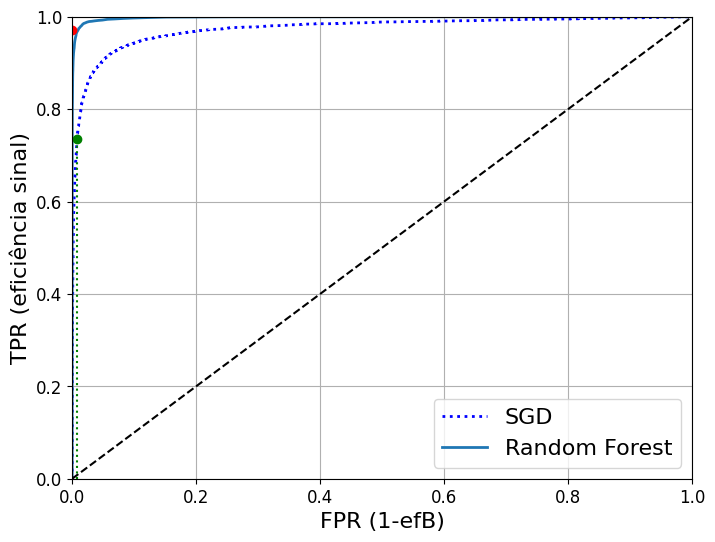

In [98]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_point, fpr_point], [0., rec_point], "g:")
plt.plot([0.0, fpr_point], [rec_point, rec_point], "g:")
plt.plot([fpr_point], [rec_point], "go")
plt.plot([fpr_pnt_frst, fpr_pnt_frst], [0., rec_pnt_frst], "r:")
plt.plot([fpr_pnt_frst], [rec_pnt_frst], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [99]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9984563317302746)

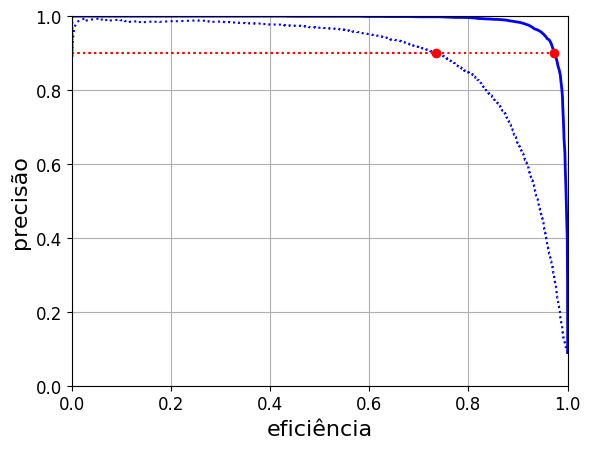

In [100]:
plt.plot(recalls,precisions,"b:")
plot_precision_vs_recall(prec_forest,rec_forest)
plt.plot([0,rec_point],[0.9,0.9],"r:")
plt.plot([rec_point],[0.9],"ro")
plt.plot([0,rec_pnt_frst],[0.9,0.9],"r:")
plt.plot([rec_pnt_frst],[0.9],"ro")
plt.show()

In [101]:
from sklearn.metrics import f1_score
## f1 = (p*r)/(p+r)
print("Score F1 para SGD ",f1_score(y_train_5, y_train_pred_90))
print("Score F1 para Random Forest ",f1_score(y_train_5, y_pred_frst_90))

Score F1 para SGD  0.808972651848817
Score F1 para Random Forest  0.9381452554089236


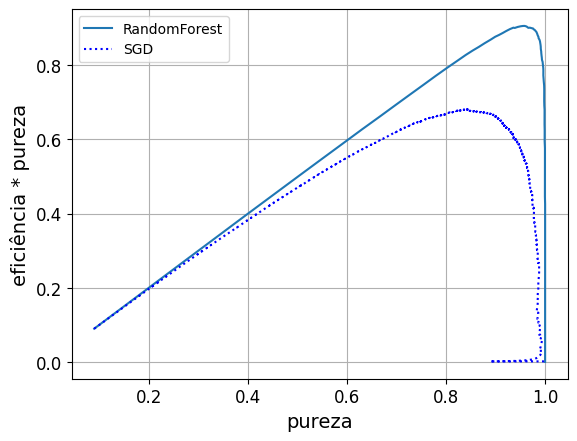

In [102]:
plt.plot(prec_forest,prec_forest*rec_forest,label="RandomForest")
plt.plot(precisions,precisions*recalls,"b:",label="SGD")
plt.grid(True)
plt.xlabel("pureza")
plt.ylabel("eficiência * pureza")
plt.legend(loc="upper left")
plt.show()

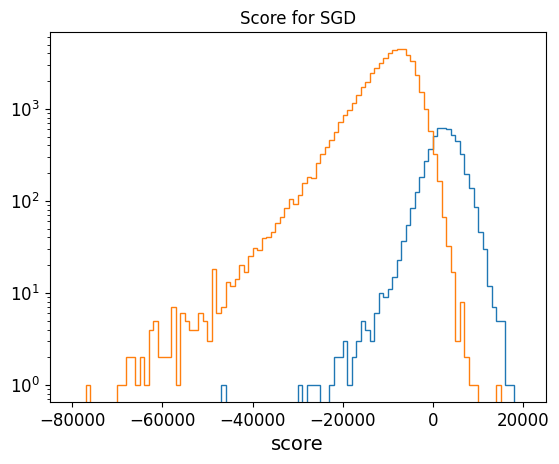

In [103]:
y_scores_only_signals = y_scores[y_train_5]
y_scores_only_backg = y_scores[~y_train_5]
#h = np.histogram(y_scores_only_signals,bins=100,range(0,1000))
plt.hist(y_scores_only_signals,bins=100,range=(-80000,20000),histtype="step")
plt.hist(y_scores_only_backg,bins=100,range=(-80000,20000),histtype="step")
plt.yscale("log")
plt.title("Score for SGD")
plt.xlabel("score")
plt.show()

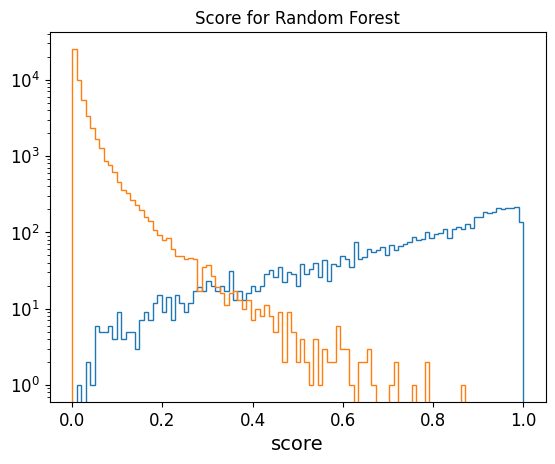

In [104]:
y_scores_only_signals_frst = y_scores_forest[y_train_5]
y_scores_only_backg_frst = y_scores_forest[~y_train_5]
#h = np.histogram(y_scores_only_signals,bins=100,range(0,1000))
plt.hist(y_scores_only_signals_frst,bins=101,range=(0.,1.),histtype="step")
plt.hist(y_scores_only_backg_frst,bins=101,range=(0.,1.),histtype="step")
plt.yscale("log")
plt.title("Score for Random Forest")
plt.xlabel("score")
plt.show()

### Amostra "reduzida" (só 3 números)

Aqui a prevalencia do "sinal"  (número 5) aumenta de 1/10 a 1/3.

In [105]:
indx = [i for i,y in enumerate(y_train) if y in ["3","5","8"]]
X_train_reduced = X_train[ indx]
y_train_5_reduced = y_train_5[indx]
print(X_train.shape)
print(X_train_reduced.shape)


(60000, 784)
(17339, 784)


In [106]:
forest_redx_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest_reduced = cross_val_predict(forest_redx_clf, X_train_reduced, y_train_5_reduced, cv=3,
                                    method="predict_proba")

In [107]:
y_scores_frst_redx = y_probas_forest_reduced[:, 1] # score = proba of positive class
fpr_frst_rdx, tpr_frst_rdx, thresholds_frst_redx = roc_curve(y_train_5_reduced,y_scores_frst_redx)
prec_frst_rdx, rec_frst_rdx, threshs_frst_redx = precision_recall_curve(y_train_5_reduced, y_scores_frst_redx)

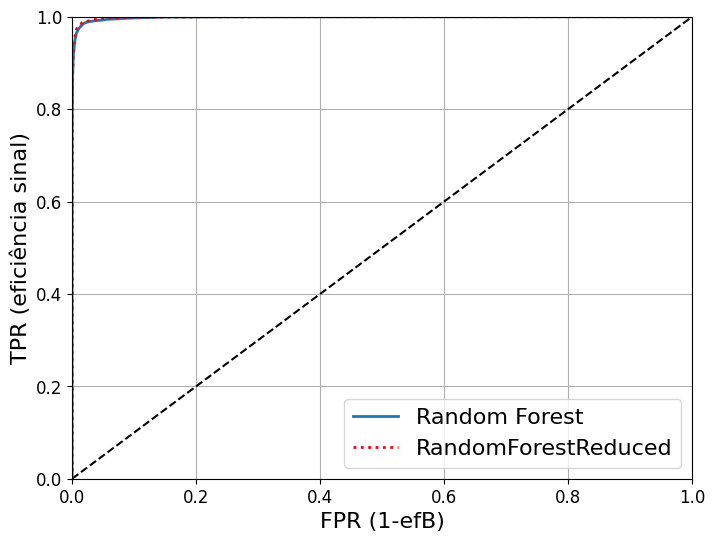

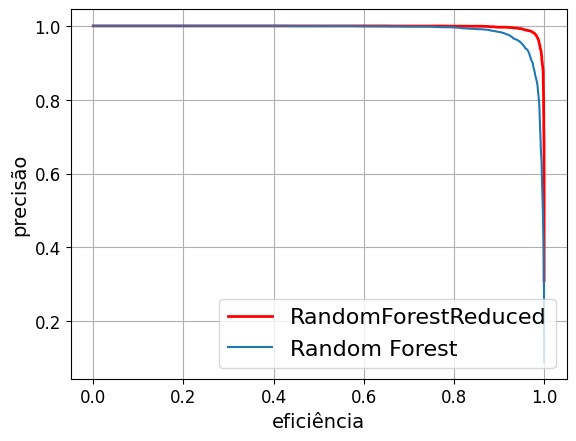

In [108]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_frst_rdx, tpr_frst_rdx, "r:", linewidth=2, label="RandomForestReduced")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

plt.plot(rec_frst_rdx,prec_frst_rdx,"r",linewidth=2,label="RandomForestReduced")
plt.plot(rec_forest,prec_forest,label="Random Forest")
plt.xlabel("eficiência")
plt.ylabel("precisão")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Nos gráficos acima podemos ver que na amostra reduzida a curva ROC não muda, mas a curva PRC mostra uma melhoria.

![texto alternativo](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/Thresh_vary_valassi.png?raw=true)

![texto](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/ROC_PRC_prevalence.png?raw=true)

![texto](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/TableDomains.png?raw=true)

## Avaliação em rede neural MLP

Podemos testar para o modelo MLP


In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.datasets import mnist
#from keras.utils import np_utils

# Trainign batch size
batch_size = 64
# Number of training epochs
epochs = 20
# Fraction of the training data to be used as validation
val_split = 0.3

# Learning rate
lr=0.1

X_train_mlp = X_train.astype('float32')
X_test_mlp = X_test.astype('float32')
X_train_mlp /= 255
X_test_mlp /= 255


In [110]:
# Multilayer Perceptron model
model = Sequential()
model.add(Dense(input_dim=784, activation="relu", units=100, kernel_initializer="normal"))
model.add(Dense(activation="relu", units=30, kernel_initializer="normal")) # after first layer no need to specify input_dim
model.add(Dense(activation="relu", units=10, kernel_initializer="normal")) # after first layer no need to specify input_dim
model.add(Dense(activation="sigmoid", units=1, kernel_initializer="normal"))
model.compile(optimizer=SGD(learning_rate=lr), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,851 (319.73 KB)

 Trainable params: 81,851 (319.73 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
history = model.fit(X_train_mlp, y_train_5, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9103 - loss: 0.1180 - val_accuracy: 0.9094 - val_loss: 0.0805
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9125 - loss: 0.0763 - val_accuracy: 0.9094 - val_loss: 0.0671
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9107 - loss: 0.0611 - val_accuracy: 0.9629 - val_loss: 0.0350
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9684 - loss: 0.0278 - val_accuracy: 0.9761 - val_loss: 0.0197
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9813 - loss: 0.0161 - val_accuracy: 0.9799 - val_loss: 0.0165
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9859 - loss: 0.0124 - val_accuracy: 0.9848 - val_loss: 0.0121
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9893 - loss: 0.0097 - val_accuracy: 0.9869 - val_loss: 0.0113
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9913 - loss: 0.0078 - val_accuracy: 0.

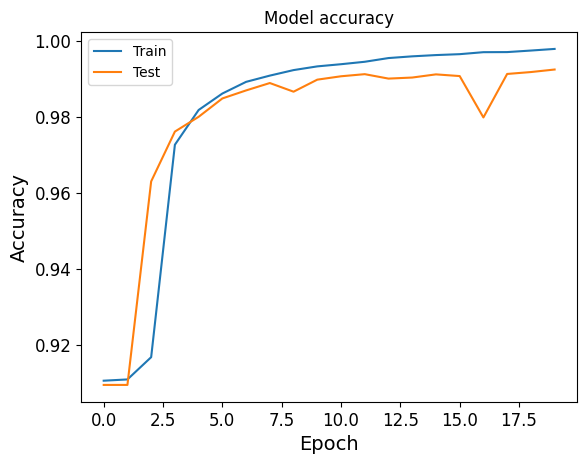

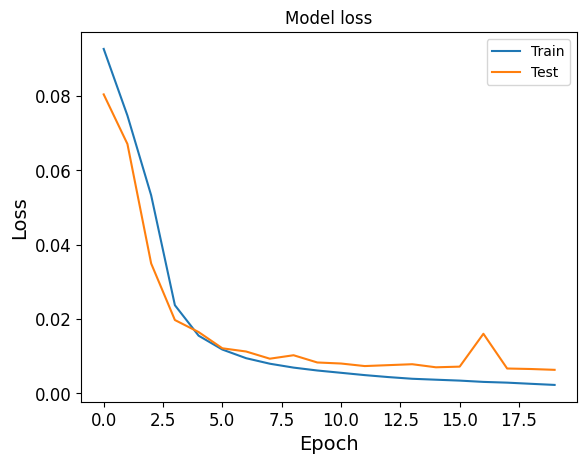

In [112]:
# Training History Visualization
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [113]:
y_predtest_mlp = model.predict(X_test_mlp)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [114]:
y_pred_mlp = model.predict(X_train_mlp)
prec_mlp, rec_mlp, thresh_mlp = precision_recall_curve(y_train_5, y_pred_mlp)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


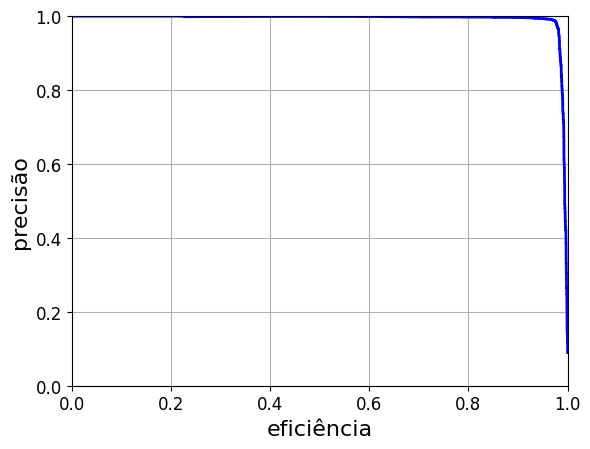

In [115]:
plot_precision_vs_recall(prec_mlp,rec_mlp)


In [116]:
fpr_mlp, tpr_mlp, threshs_mlp = roc_curve(y_train_5, y_pred_mlp)

0.9979017983820561


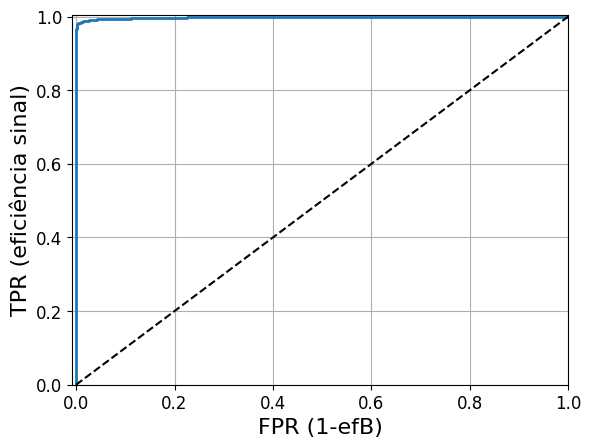

In [123]:
plot_roc_curve(fpr_mlp,tpr_mlp)
plt.axis([-0.008,1,0.0,1.004])

print(roc_auc_score(y_train_5,y_pred_mlp))

In [124]:
print(roc_auc_score(y_test_5,y_predtest_mlp))

0.9979007377622621


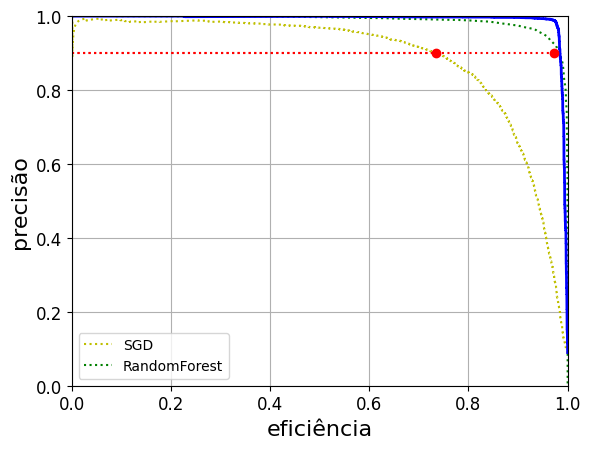

In [125]:
plt.plot(recalls,precisions,"y:",label="SGD")
plt.plot(prec_forest,rec_forest,"g:",label="RandomForest")
plot_precision_vs_recall(prec_mlp,rec_mlp)
plt.plot([0,rec_point],[0.9,0.9],"r:")
plt.plot([rec_point],[0.9],"ro")
plt.plot([0,rec_pnt_frst],[0.9,0.9],"r:")
plt.plot([rec_pnt_frst],[0.9],"ro")
plt.legend(loc="lower left")

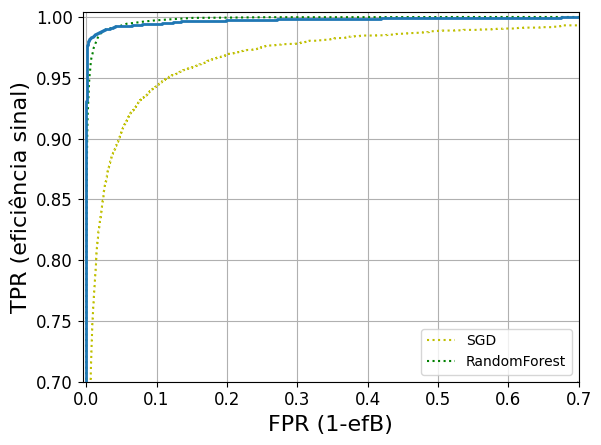

In [120]:
plt.plot(fpr,tpr,"y:",label="SGD")
plt.plot(fpr_forest,tpr_forest,"g:",label="RandomForest")
plot_roc_curve(fpr_mlp,tpr_mlp)
plt.axis([-0.005,0.7,0.7,1.004])

plt.legend(loc="lower right")

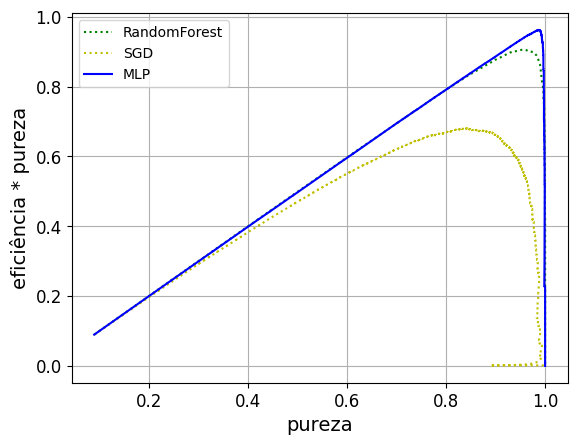

In [121]:
plt.plot(prec_forest,prec_forest*rec_forest,"g:",label="RandomForest")
plt.plot(precisions,precisions*recalls,"y:",label="SGD")
plt.plot(prec_mlp,rec_mlp*prec_mlp,"blue",label="MLP")
plt.grid(True)
plt.xlabel("pureza")
plt.ylabel("eficiência * pureza")
plt.legend(loc="upper left")
plt.show()

Para achar o ponto com o melhor valor de _threshold_ em função da precisão x eficiência:

Melhor Eficiencia:  0.9748883928571429  Melhor precisão:  0.9870056497175141
Melhor valor do threshold:  0.50572646


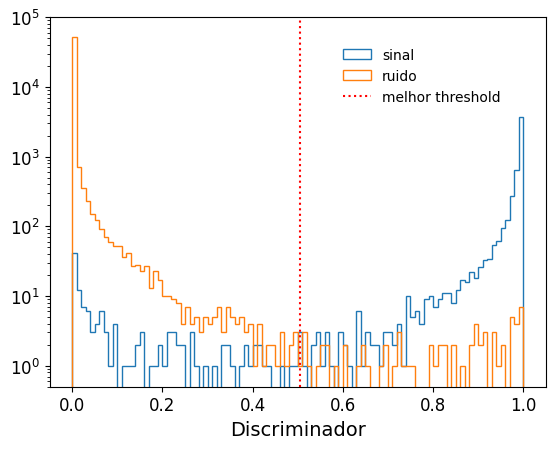

In [130]:
idxmaxeffpur = np.argmax(prec_mlp*rec_mlp)
#effpurmax = np.max(prec_mlp*rec_mlp)
#print(effpurmax,idxmaxeffpur)
print("Melhor Eficiencia: ",rec_mlp[idxmaxeffpur]," Melhor precisão: ",prec_mlp[idxmaxeffpur])
best_thresh_mlp=thresh_mlp[np.argmax(prec_mlp>=prec_mlp[idxmaxeffpur])]
print("Melhor valor do threshold: ",best_thresh_mlp)
y_pred_mlp_best = (y_pred_mlp>= best_thresh_mlp)
f1_score(y_train_5,y_pred_mlp_best)
plt.hist(y_pred_mlp[y_train_5] ,bins=100,range=(0,1),histtype='step',label="sinal")
plt.hist(y_pred_mlp[~y_train_5],bins=100,range=(0,1),histtype='step',label="ruido")
plt.plot([best_thresh_mlp,best_thresh_mlp],[0.5,1e5],"r:",label="melhor threshold")
plt.axis([-0.05,1.05,0.5,1e5])
plt.yscale("log")
plt.xlabel("Discriminador")
plt.legend(loc=(0.58,0.75),frameon=False)
plt.show()